In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [94]:
def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term


def modified_swift_voce(strain, A, B, n, Q, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = Q * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping

def r_value(strain, c1, c2, c3):
        return c1 + c2 * (1-np.exp(-c3 * strain))


# Normal Swift-Voce fitting

In [27]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 500, 0.01, 0.2, 300, 200, 10]

# Fit the curve
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=100000)
    
# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)

    '''
    # Export stress and strain values
    stress_difference = stress - fitted_stress
    
    # Create a DataFrame with the required columns
    df = pd.DataFrame({
        'Experimental Strain': strain,
        'Experimental Stress': stress,
        'Fitted Stress': fitted_stress,
        'Stress Difference': stress_difference
    })
    extracted_strain = np.arange(0.1, 3.01, 0.01)
    extracted_stress = swift_voce(extracted_strain, *params)
    df2 = pd.DataFrame({
        'Extended Strain': extracted_strain,
        'Extended Stress': extracted_stress,
    })

    # Save the DataFrame to an Excel file with the file name based on the `title` argument
    output_file_path = f"{title}_stress_strain_comparison.xlsx"
    with pd.ExcelWriter(output_file_path) as writer:
        df.to_excel(writer, sheet_name='Comparison', index=False)
        df2.to_excel(writer, sheet_name='Extended Fit', index=False)
    
    print(f"Data has been exported to {output_file_path}")
    '''
    return params, extended_stress, extended_strain
   

# Modified Swift-Voce fitting with damping value for high strain

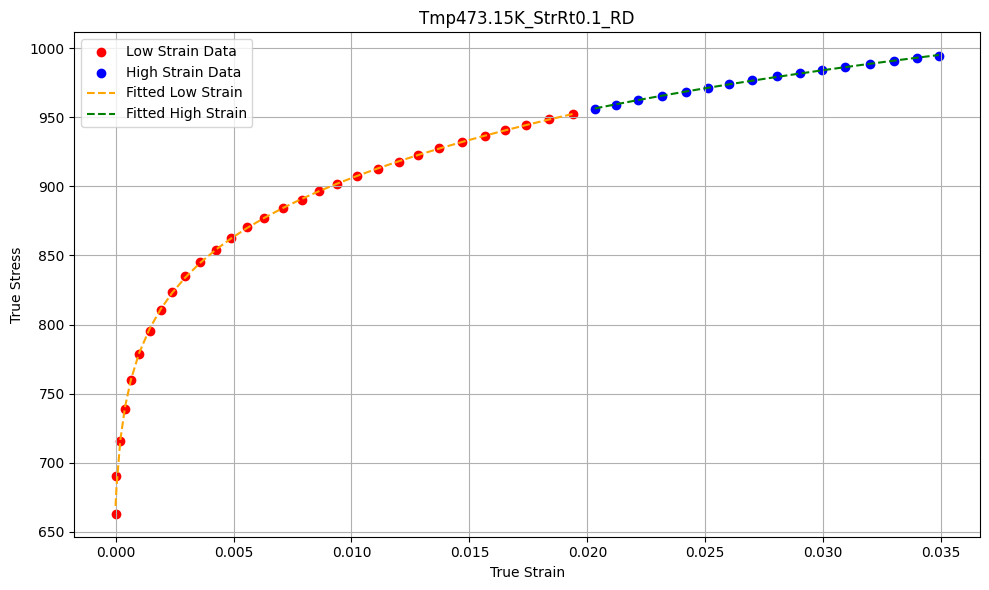

Fitted Parameters for Low Strain (<0.02):
A: 1223.7003, B: 49.4710, n: 0.0663, Q: 2184.8639, Epsilon_0: 0.0001, Alpha: 0.5332, Beta: 20.0000
Fitted Parameters for High Strain (>=0.02):
A: 1272.7564, B: 16.1398, n: 0.0733, Q: 567.5652, Epsilon_0: 0.0000, Alpha: 0.0000, Beta: 7.2264


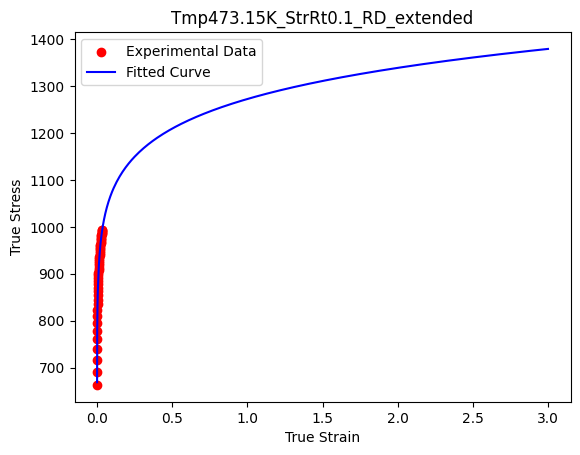

(array([1.22370026e+03, 4.94709809e+01, 6.63265899e-02, 2.18486388e+03,
        1.10223467e-04, 5.33209650e-01, 2.00000000e+01]),
 array([1.27275638e+03, 1.61397681e+01, 7.33382326e-02, 5.67565173e+02,
        9.32342797e-21, 3.30320324e-20, 7.22635822e+00]))

In [31]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([500, 0, 0, 500, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Separate data into low and high strain regions
    low_strain = strain[strain < 0.02]
    low_stress = stress[strain < 0.02]

    high_strain = strain[strain >= 0.02]
    high_stress = stress[strain >= 0.02]

    # Fit the curve for low strain data
    params_low, _ = curve_fit(
        modified_swift_voce, low_strain, low_stress, p0=initial_guess, bounds=bounds
    )

    # Fit the curve for high strain data
    params_high, _ = curve_fit(
        modified_swift_voce, high_strain, high_stress, p0=initial_guess, bounds=bounds
    )

    # Extract fitted stress values
    fitted_low_stress = modified_swift_voce(low_strain, *params_low)
    fitted_high_stress = modified_swift_voce(high_strain, *params_high)

    # Plot experimental and fitted curves
    plt.figure(figsize=(10, 6))
    plt.scatter(low_strain, low_stress, label='Low Strain Data', color='red')
    plt.scatter(high_strain, high_stress, label='High Strain Data', color='blue')
    plt.plot(low_strain, fitted_low_stress, color='orange', linestyle='--', label='Fitted Low Strain')
    plt.plot(high_strain, fitted_high_stress, color='green', linestyle='--', label='Fitted High Strain')
    
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print fitted parameters for both regions
    print(f'Fitted Parameters for Low Strain (<0.02):\n'
          f'A: {params_low[0]:.4f}, B: {params_low[1]:.4f}, n: {params_low[2]:.4f}, '
          f'Q: {params_low[3]:.4f}, Epsilon_0: {params_low[4]:.4f}, '
          f'Alpha: {params_low[5]:.4f}, Beta: {params_low[6]:.4f}')

    print(f'Fitted Parameters for High Strain (>=0.02):\n'
          f'A: {params_high[0]:.4f}, B: {params_high[1]:.4f}, n: {params_high[2]:.4f}, '
          f'Q: {params_high[3]:.4f}, Epsilon_0: {params_high[4]:.4f}, '
          f'Alpha: {params_high[5]:.4f}, Beta: {params_high[6]:.4f}')

    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    low_stress = modified_swift_voce(extended_strain[extended_strain < 0.02], *params_low)
    high_stress = modified_swift_voce(extended_strain[extended_strain >= 0.02], *params_high)
    extended_stress = np.concatenate((low_stress, high_stress))
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()

    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    return params_low, params_high

#condition = 'Tmp298.15K_StrRt1_RD'
condition = 'Tmp473.15K_StrRt0.1_RD'
analyze_msv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp473.csv', condition + '_E', condition + '_S', condition)


# Plot of all strain rate and parameters relationship

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


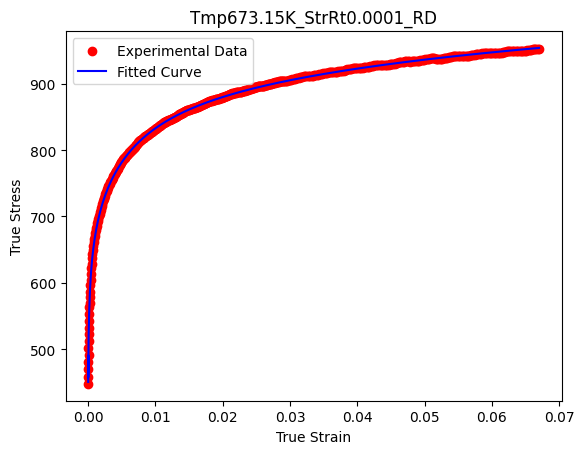

Fitted Parameters:
Alpha: 0.4608
A: 1071120.6963
Epsilon_0: 0.0000
n: 0.0001
K0: -913371.6424
Q: 73.1414
Beta: 183.6771

Error Metrics:
MSE: 5.3673
RMSE: 2.3167
MAE: 1.0788
R-squared: 0.9994


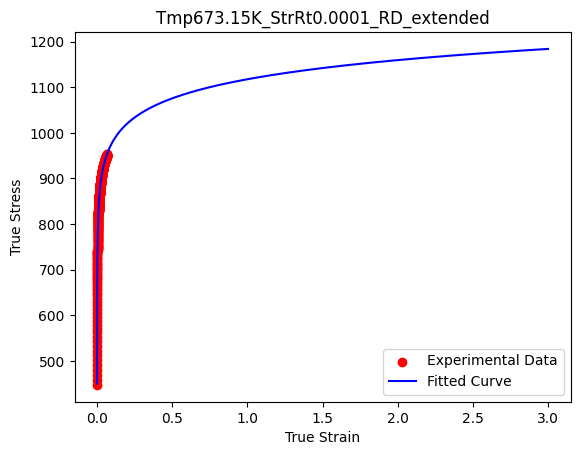

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


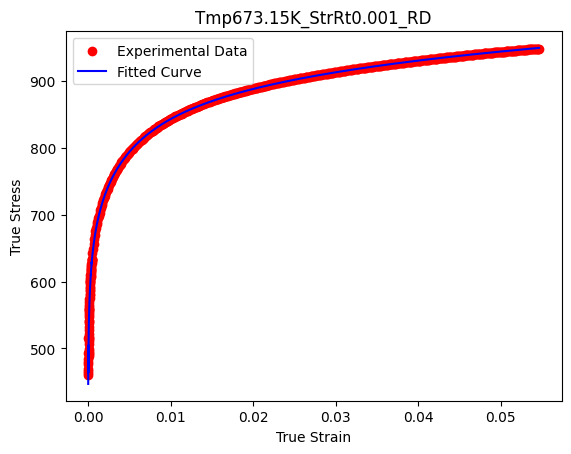

Fitted Parameters:
Alpha: 0.4578
A: 952214.0175
Epsilon_0: 0.0000
n: 0.0001
K0: -801826.5646
Q: 59.1985
Beta: 228.1955

Error Metrics:
MSE: 10.0890
RMSE: 3.1763
MAE: 1.0046
R-squared: 0.9993


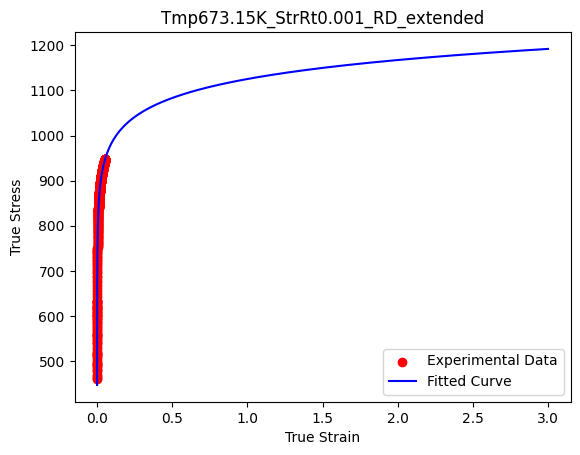

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


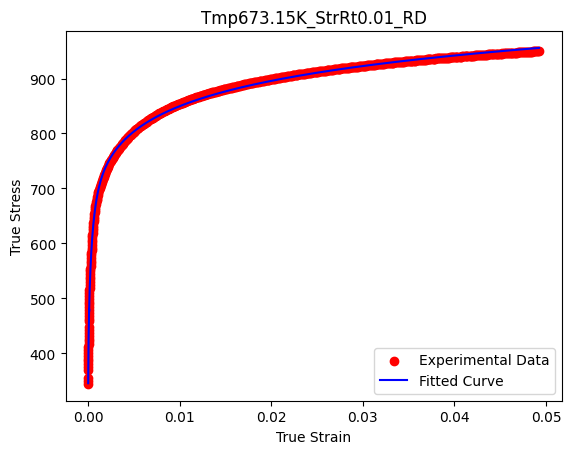

Fitted Parameters:
Alpha: 0.4358
A: 1402929.7554
Epsilon_0: 0.0000
n: 0.0001
K0: -1081807.2686
Q: 176.0583
Beta: 2373.7123

Error Metrics:
MSE: 27.3549
RMSE: 5.2302
MAE: 3.6027
R-squared: 0.9985


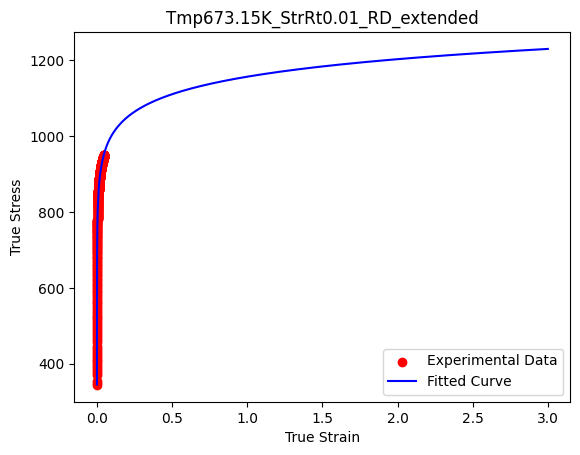

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


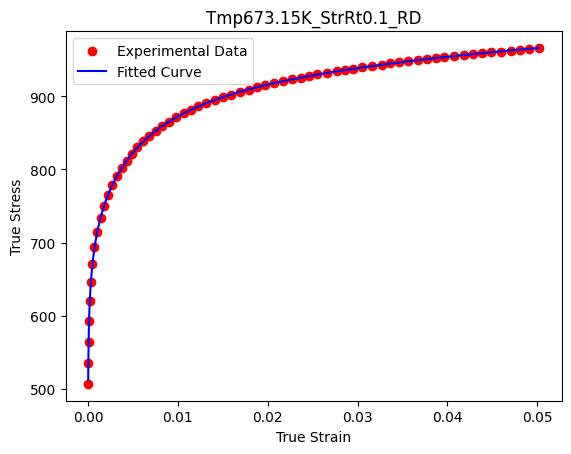

Fitted Parameters:
Alpha: 0.4645
A: 285977.1675
Epsilon_0: 0.0000
n: 0.0004
K0: -246088.9324
Q: 100.4017
Beta: 197.2025

Error Metrics:
MSE: 4.5256
RMSE: 2.1273
MAE: 0.8415
R-squared: 0.9997


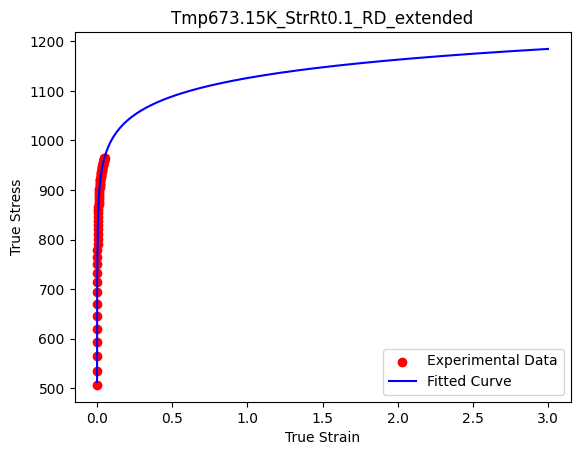

"\nfor i in range(7):\n    plt.figure(figsize=(8, 5))  # Create a new figure for each plot\n    plt.plot(conditions, [p[i] for p in params], marker='o')\n    plt.xlabel('Conditions')\n    plt.xticks(rotation=60)\n    plt.ylabel(params_name[i])\n    plt.title(params_name[i] + ' of Each Condition')\n    plt.tight_layout()  # Adjust layout to prevent label cut-off\n    plt.show()  # Display the plot\n"

In [37]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']

#conditions = ['Tmp77.15K_StrRt0.0001_RD']
#conditions = ['Tmp233.15K_StrRt0.0001_RD']
#conditions = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
#conditions = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
#conditions = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
#conditions = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
conditions = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']

for condition in conditions:
    params.append(analyze_sv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp673.csv', condition + '_E', condition + '_S', condition))
'''
for i in range(7):
    plt.figure(figsize=(8, 5))  # Create a new figure for each plot
    plt.plot(conditions, [p[i] for p in params], marker='o')
    plt.xlabel('Conditions')
    plt.xticks(rotation=60)
    plt.ylabel(params_name[i])
    plt.title(params_name[i] + ' of Each Condition')
    plt.tight_layout()  # Adjust layout to prevent label cut-off
    plt.show()  # Display the plot
'''

# r value fitting and generation

In [95]:
def analyze_r_fit(file_path, strain_column, r_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    r = data[r_column].dropna().values
    
    # Initial guesses for parameters [c1, c2, c3]
    if initial_guess is None:
        initial_guess = [0.42, 0.31, 88.33]  # Adjusted initial guess for r_value

    # Fit the curve
    params, _ = curve_fit(r_value, strain, r, p0=initial_guess, maxfev=100000)
    
    # Extract fitted parameters
    c1, c2, c3 = params

    # Plot the experimental data and the fitted curve_
    fitted_r= r_value(strain, *params)
    plt.scatter(strain, r, label='Experimental Data', color='red')
    plt.plot(strain, fitted_r, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('r value')
    plt.title(title)
    plt.legend()
    plt.show()

    # Print fitted parameters
    print(f'Fitted Parameters:\nC1: {c1:.4f}\nC2: {c2:.4f}\nC3: {c3:.4f}\n')
    
    # Calculate error metrics
    mse = np.mean((r - fitted_r) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(r - fitted_r))
    r_squared = 1 - np.sum((r - fitted_r) ** 2) / np.sum((r - np.mean(r)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
    # Extended strain 
    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_r = r_value(extended_strain, *params)
    plt.scatter(strain, r, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_r, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('r value')
    plt.title(f"{title}_extended_r_value")
    plt.legend()
    plt.show()
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'strain': extended_strain,
        'r_value': extended_r
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_r/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)

    return params, extended_r, extended_strain


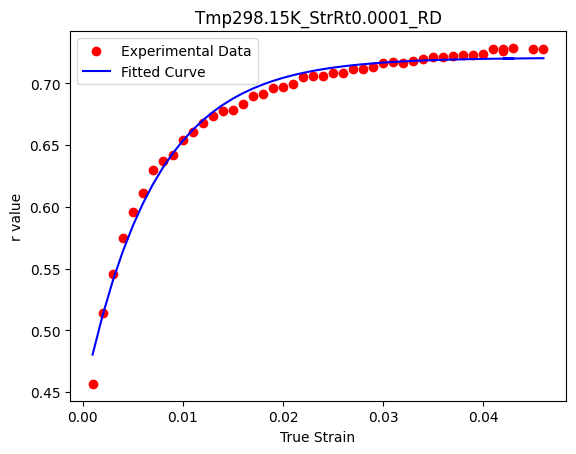

Fitted Parameters:
C1: 0.4437
C2: 0.2771
C3: 141.5863

Error Metrics:
MSE: 0.0000
RMSE: 0.0068
MAE: 0.0054
R-squared: 0.9872


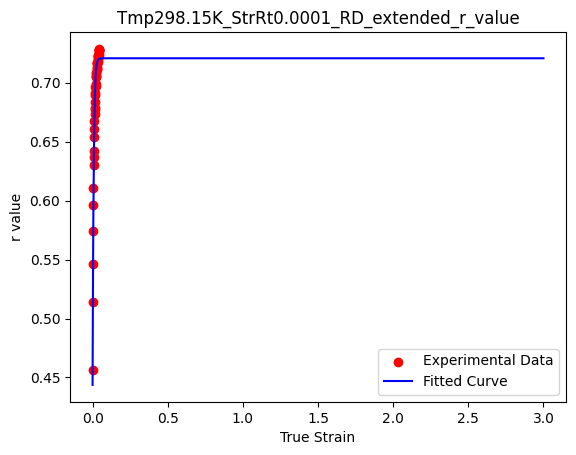

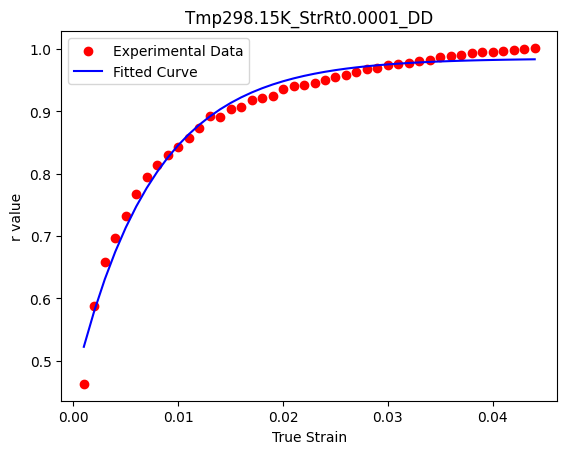

Fitted Parameters:
C1: 0.4564
C2: 0.5284
C3: 133.3517

Error Metrics:
MSE: 0.0002
RMSE: 0.0152
MAE: 0.0118
R-squared: 0.9834


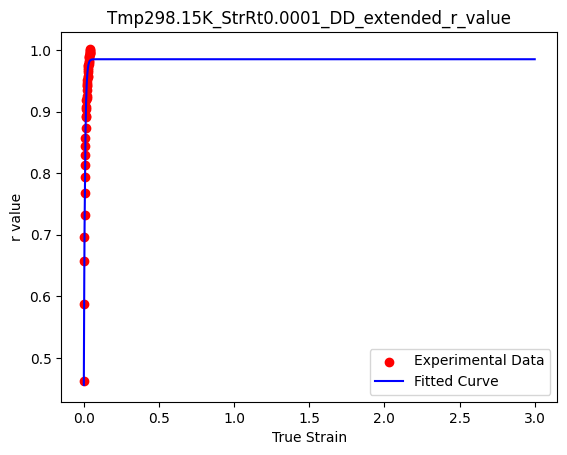

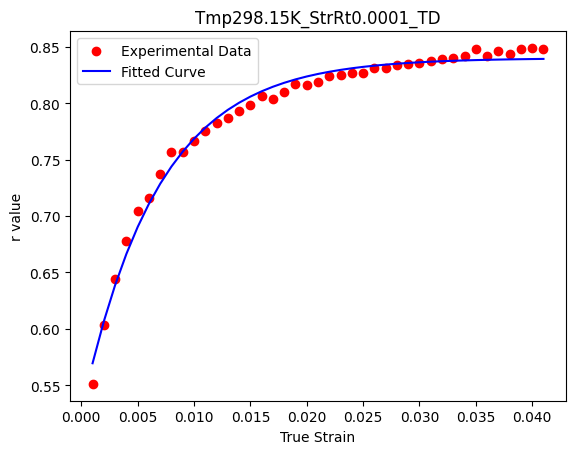

Fitted Parameters:
C1: 0.5263
C2: 0.3136
C3: 147.8721

Error Metrics:
MSE: 0.0001
RMSE: 0.0071
MAE: 0.0059
R-squared: 0.9894


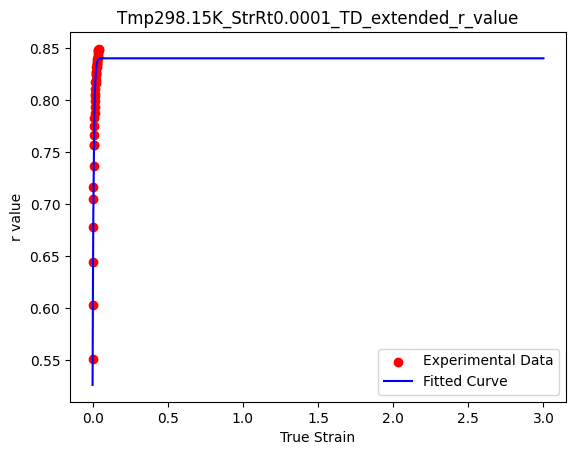

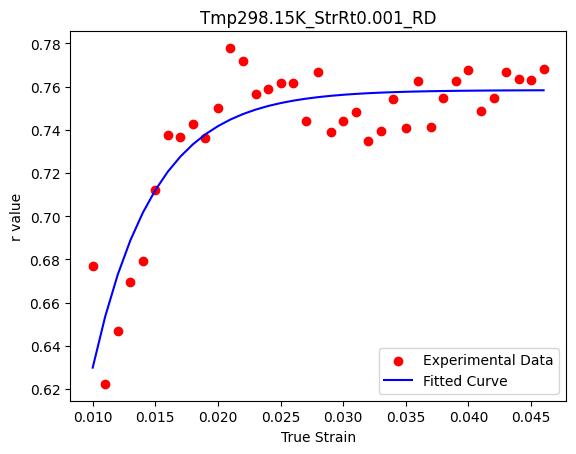

Fitted Parameters:
C1: -0.2312
C2: 0.9896
C3: 204.1095

Error Metrics:
MSE: 0.0003
RMSE: 0.0163
MAE: 0.0130
R-squared: 0.7866


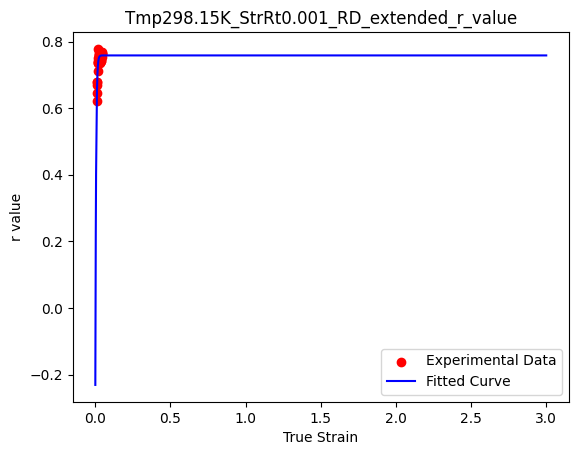

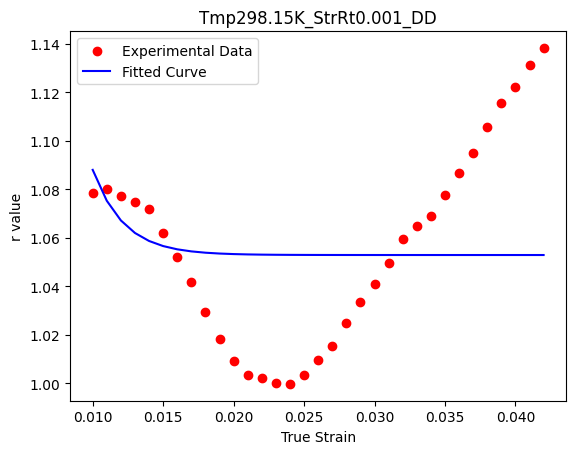

Fitted Parameters:
C1: 4.2347
C2: -3.1818
C3: 450.6071

Error Metrics:
MSE: 0.0016
RMSE: 0.0394
MAE: 0.0321
R-squared: 0.0338


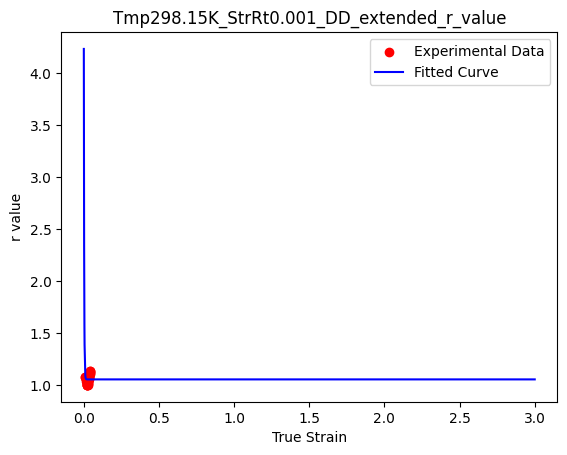

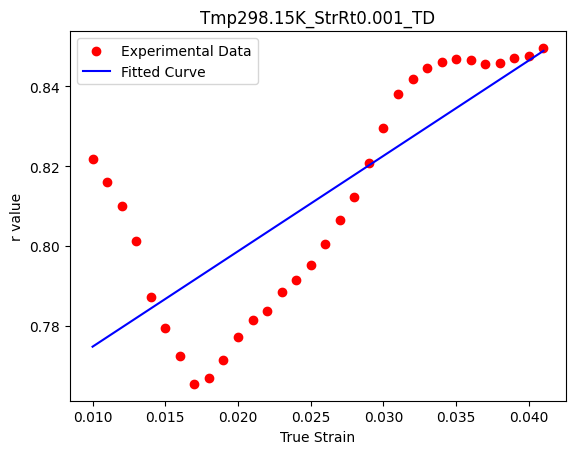

Fitted Parameters:
C1: 0.7508
C2: 393.6549
C3: 0.0061

Error Metrics:
MSE: 0.0003
RMSE: 0.0185
MAE: 0.0150
R-squared: 0.5891


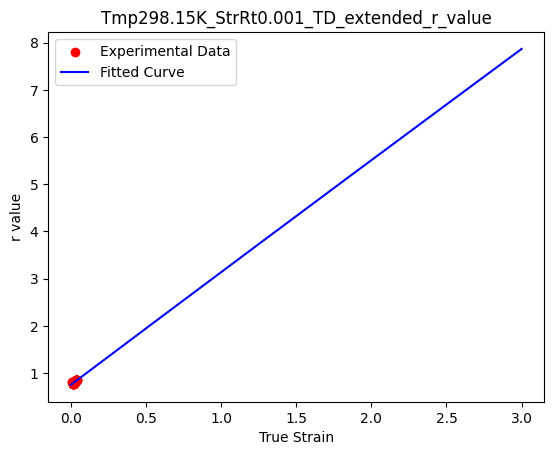

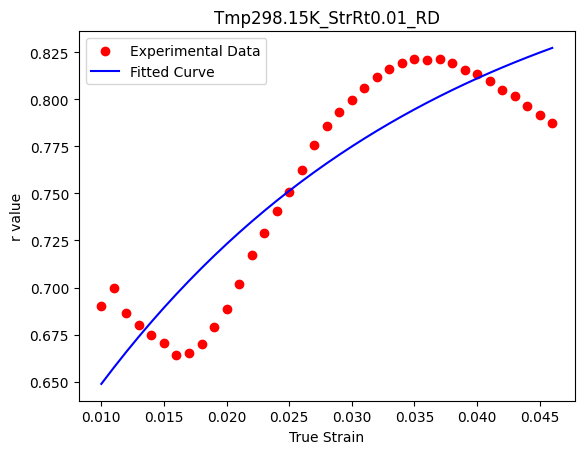

Fitted Parameters:
C1: 0.5422
C2: 0.3523
C3: 36.0340

Error Metrics:
MSE: 0.0006
RMSE: 0.0249
MAE: 0.0219
R-squared: 0.8154


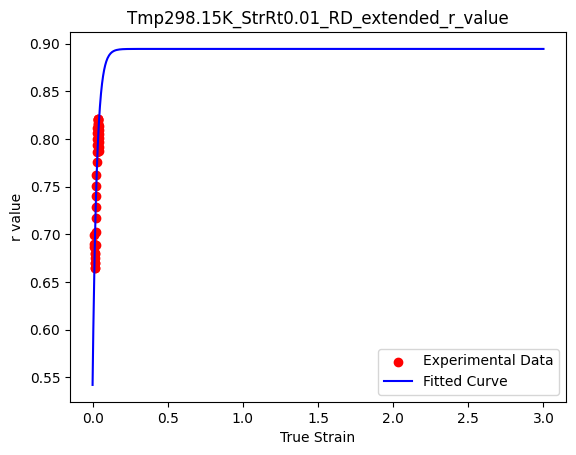

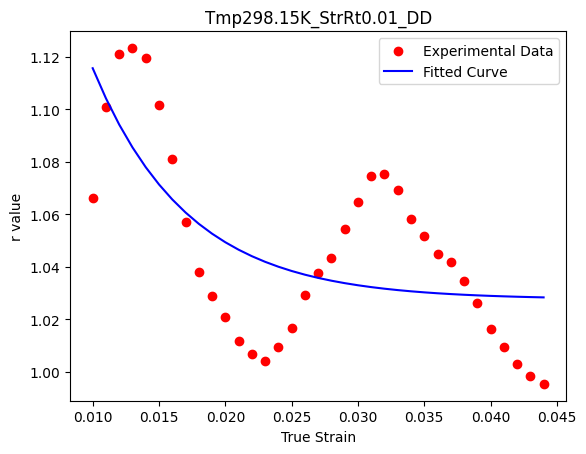

Fitted Parameters:
C1: 1.3835
C2: -0.3558
C3: 139.7742

Error Metrics:
MSE: 0.0007
RMSE: 0.0273
MAE: 0.0240
R-squared: 0.4199


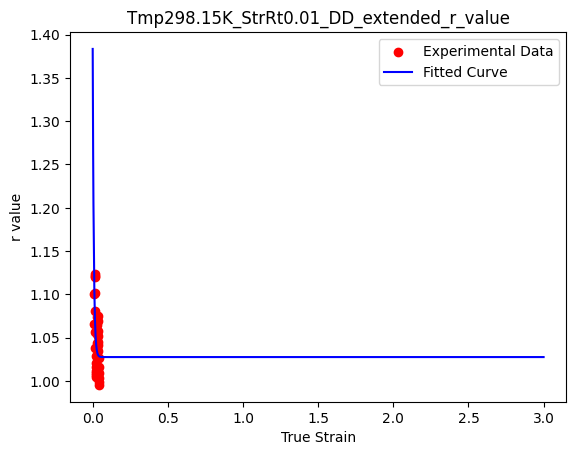

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


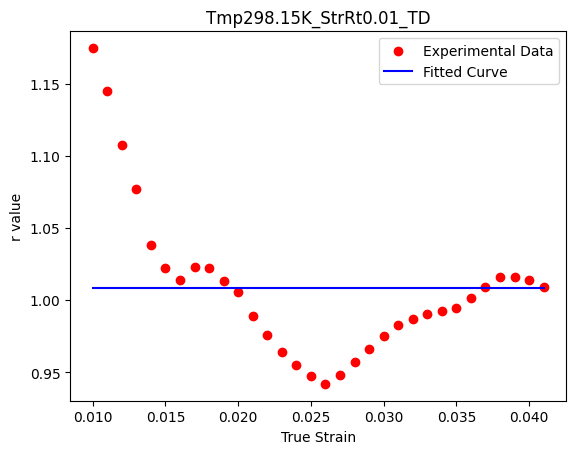

Fitted Parameters:
C1: 0.8518
C2: 0.1568
C3: 2375.4021

Error Metrics:
MSE: 0.0028
RMSE: 0.0525
MAE: 0.0358
R-squared: -0.0000


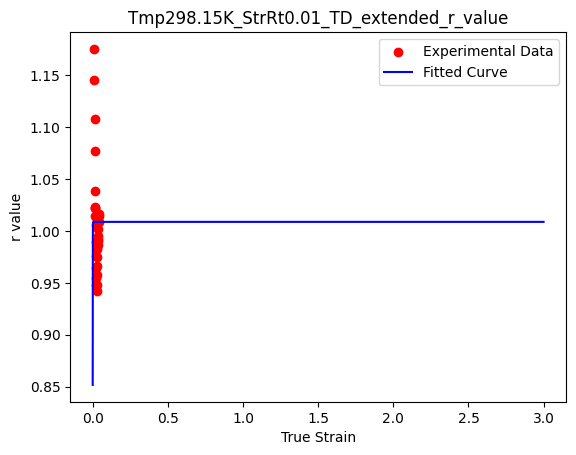

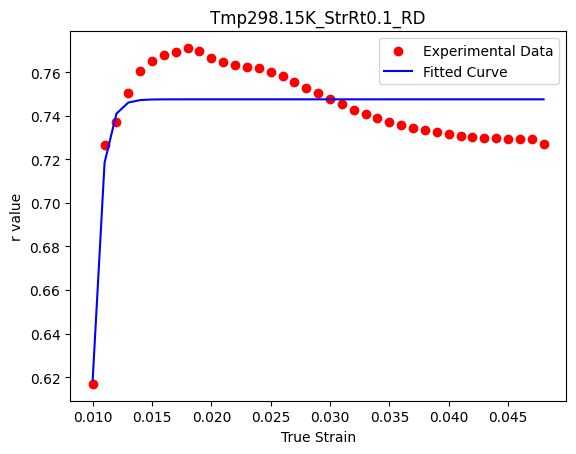

Fitted Parameters:
C1: -371136.2092
C2: 371136.9568
C3: 1487.3948

Error Metrics:
MSE: 0.0002
RMSE: 0.0145
MAE: 0.0130
R-squared: 0.6736


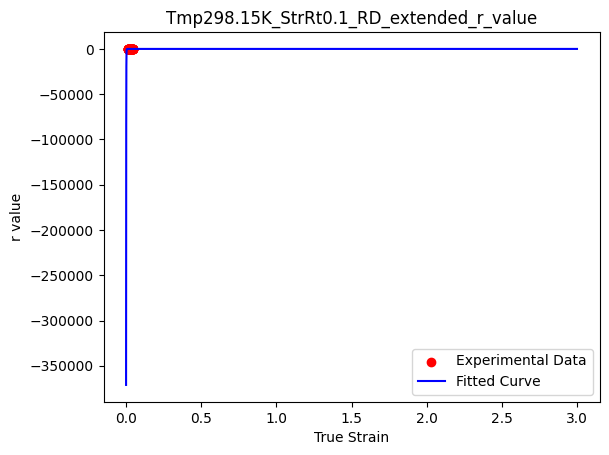

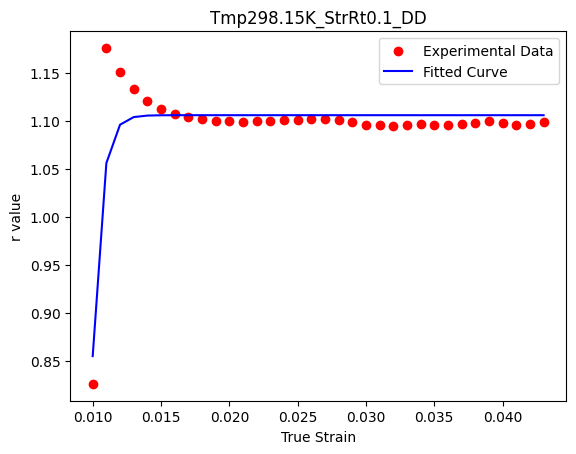

Fitted Parameters:
C1: -2599032.1684
C2: 2599033.2740
C3: 1615.4445

Error Metrics:
MSE: 0.0006
RMSE: 0.0248
MAE: 0.0133
R-squared: 0.7536


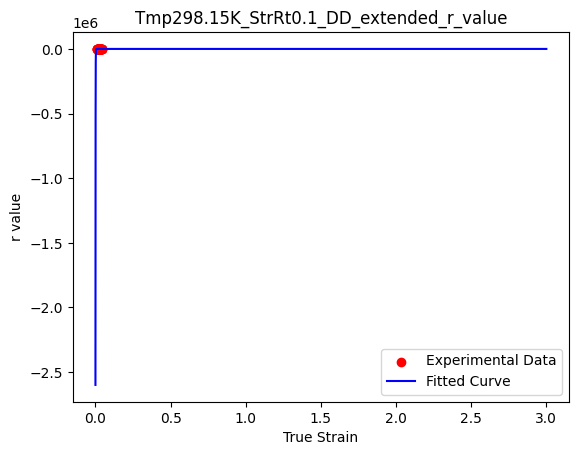

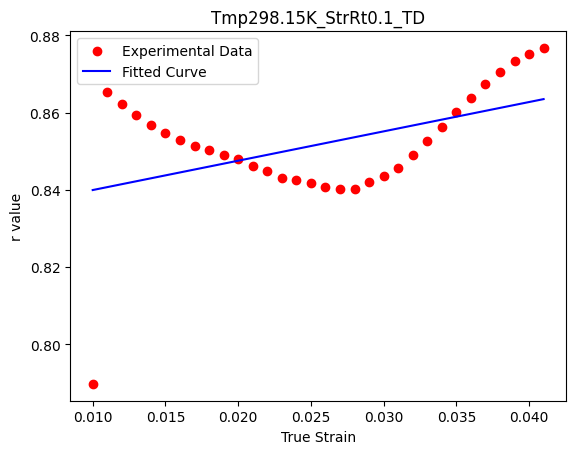

Fitted Parameters:
C1: 0.8323
C2: 145.3066
C3: 0.0052

Error Metrics:
MSE: 0.0002
RMSE: 0.0138
MAE: 0.0104
R-squared: 0.2058


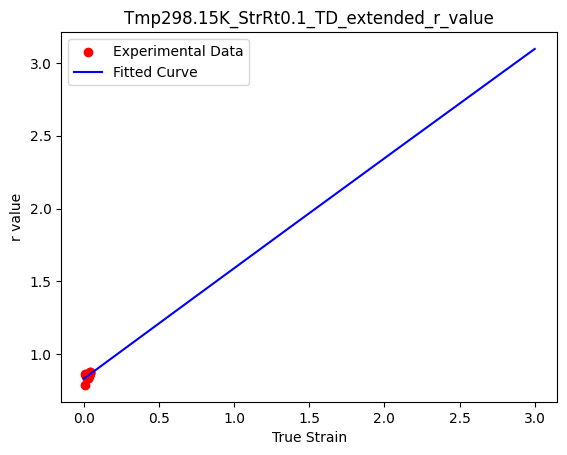

In [96]:
#conditions = ['Tmp77.15K_StrRt0.0001_RD']
#conditions = ['Tmp233.15K_StrRt0.0001_RD']
conditions = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
#conditions = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
#conditions = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
#conditions = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
#conditions = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']

for condition in conditions:
    analyze_r_fit('data/Exp_rV_StrRtDpn_Tmp298.csv', condition + '_E', condition + '_r', condition)

# Calculating ratio between RD, TD, DD, biaxial and generate files for stress-strain simulation

In [61]:
directions = ['RD', 'DD', 'TD']
ref_temp = '298.15'

#temps = ['77.15', '233.15']
#strain_rates = [0.0001]

strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

#RD-biaxial ratio from Zinan file
data_biax = pd.read_csv('data/strain_extended.csv')
ratio_biax = data_biax['biaxial']/data_biax['RD']

for strain_rate in strain_rates:
    data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_DD.csv')
    data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_TD.csv')
    
    #RD-DD and RD-TD ratio
    ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

    #Generate TD, DD, biaxial for all conditions
    for temp in temps:
        #Read in RD data
        temp_RD = pd.read_csv(f'extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        df = pd.DataFrame({
        'strain': data_RD['Strain'],
        'RD': temp_RD,
        'DD': temp_RD * ratio[0],
        'TD': temp_RD * ratio[1],
        'biaxial': temp_RD * ratio[2]
    })

        # Save the DataFrame to a CSV file
        output_file_path = f"inp_file/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
        df.to_csv(output_file_path, index=False)